In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.preprocessing.image import ImageDataGenerator
# from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception,MobileNetV3Small, MobileNetV2
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)



Mounted at /content/gdrive


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top = False, input_shape = (150, 150, 3))
# base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 75, 75, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

**Importing Pre_trained Model to apply Transfer Learning**

## Creating Training Data
**Set Up the Scenes Dataset**

In [ ]:
# Training Set Directory
dir='/content/gdrive/MyDrive/DataSet/train-scene classification/train'
dataset = pd.read_csv("/content/gdrive/MyDrive/DataSet/train-scene classification/train.csv")    # Dataframe
dataset["label"] = dataset["label"].astype(str) # Converting Class number to strings

print(dataset)

      image_name label
0          0.jpg     0
1          1.jpg     4
2          2.jpg     5
3          4.jpg     0
4          7.jpg     4
...          ...   ...
17029  24325.jpg     4
17030  24328.jpg     3
17031  24329.jpg     3
17032  24332.jpg     5
17033  24334.jpg     2

[17034 rows x 2 columns]


## Splitting Data into Train/Test

In [ ]:
data_train, data_test = train_test_split(dataset, test_size=0.2)                   # Splitting in 80:20

In [ ]:
print(data_test)

      image_name label
9181   13075.jpg     1
2584    3658.jpg     3
15369  21982.jpg     2
10262  14635.jpg     4
8044   11470.jpg     5
...          ...   ...
2792    3941.jpg     3
1535    2181.jpg     3
6651    9531.jpg     3
3021    4303.jpg     3
10757  15346.jpg     0

[3407 rows x 2 columns]


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 150
size = (IMG_SIZE, IMG_SIZE)

## Creating Keras Image Data Flow


In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)


valid_generator = valid_datagen.flow_from_dataframe(dataframe = data_test,           # Training Dataframe
                                      directory = dir,                   # Training set Directory
                                      batch_size = BATCH_SIZE,                    # Size of Batch
                                      class_mode = "categorical",         # Type of Labels
                                      x_col = "image_name",               # Input Column
                                      color_mode = "rgb",                 # Image Format
                                      y_col = "label",                    # Target Column
                                      target_size = size)            # Image Size

do_data_augmentation = True
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen


train_generator = train_datagen.flow_from_dataframe(dataframe = data_train,           # Training Dataframe
                                      directory = dir,                   # Training set Directory
                                      batch_size = BATCH_SIZE,                    # Size of Batch
                                      class_mode = "categorical",         # Type of Labels
                                      x_col = "image_name",               # Input Column
                                      color_mode = "rgb",                 # Image Format
                                      y_col = "label",                    # Target Column
                                      target_size = size)            # Image Size




Found 3407 validated image filenames belonging to 6 classes.
Found 13627 validated image filenames belonging to 6 classes.


## Building Model

In [ ]:
from keras import Model 
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D, BatchNormalization
from keras.models import Sequential

In [ ]:
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=64, activation='relu')(x)
x = Dense(units=128, activation='relu')(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(units=6, activation='softmax')(x)
model = Model(base_model.input, output)
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 75, 75, 32)   0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

### Setting Loss function, Optimizer and Compling the model

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

### Compiling the Model

In [ ]:
steps_per_epoch=train_generator.samples//train_generator.batch_size
validation_steps=valid_generator.samples//valid_generator.batch_size
initial_epochs = 10
print(steps_per_epoch)
print(validation_steps)

425
106


In [ ]:
transfer_learning_history = model.fit(
    train_generator,
    epochs=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps)

Epoch 1/10
425/425 [==============================] - 96s 220ms/step - loss: 1.2206 - accuracy: 0.5180 - val_loss: 0.4548 - val_accuracy: 0.8252
Epoch 2/10
425/425 [==============================] - 93s 219ms/step - loss: 0.5189 - accuracy: 0.8121 - val_loss: 0.3645 - val_accuracy: 0.8712
Epoch 3/10
425/425 [==============================] - 93s 219ms/step - loss: 0.4588 - accuracy: 0.8351 - val_loss: 0.3418 - val_accuracy: 0.8756
Epoch 4/10
425/425 [==============================] - 93s 219ms/step - loss: 0.4307 - accuracy: 0.8430 - val_loss: 0.3335 - val_accuracy: 0.8729
Epoch 5/10
425/425 [==============================] - 93s 219ms/step - loss: 0.4253 - accuracy: 0.8401 - val_loss: 0.3138 - val_accuracy: 0.8815
Epoch 6/10
425/425 [==============================] - 93s 219ms/step - loss: 0.3867 - accuracy: 0.8585 - val_loss: 0.3137 - val_accuracy: 0.8827
Epoch 7/10
425/425 [==============================] - 93s 218ms/step - loss: 0.3852 - accuracy: 0.8571 - val_loss: 0.3000 - val_ac

## Visualizing accuracy and loss

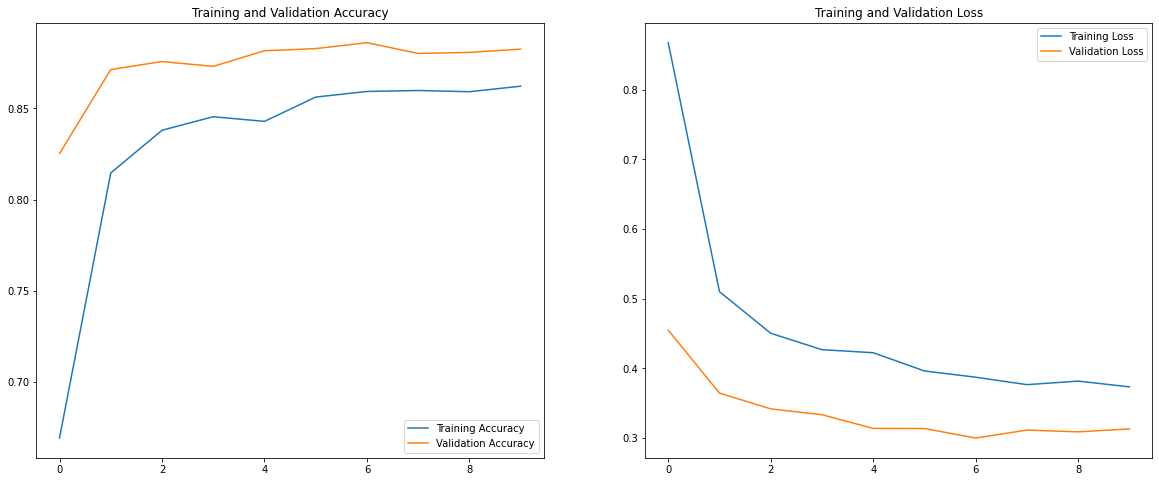

In [ ]:
import matplotlib.pyplot as plt

acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('/content/gdrive/MyDrive/models/01/')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/models/01/assets


In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/gdrive/MyDrive/models/01/')

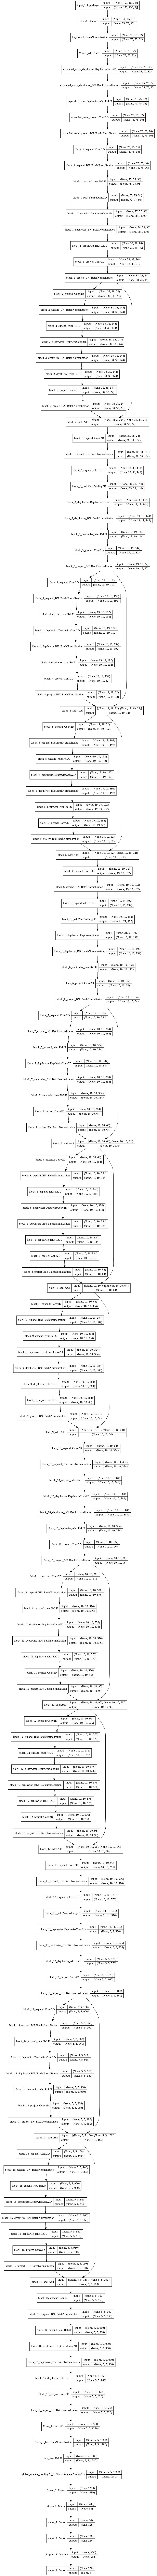

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

In [ ]:
print(transfer_learning_history.history['val_accuracy'])

[0.8251768946647644, 0.8711674809455872, 0.8755896091461182, 0.8729363083839417, 0.8814858198165894, 0.8826650977134705, 0.8859080076217651, 0.880011796951294, 0.8806014060974121, 0.8823702931404114]


In [ ]:
for layer in model.layers[:]:
    layer.trainable = False
for layer in model.layers[-54:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

In [ ]:
for i,layer in enumerate(model.layers):
    print(i,layer.name,layer.trainable)


0 input_1 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 75, 75, 32)   0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])
fine_tuning_history = model.fit(
    train_generator,
    epochs = total_epochs,
    initial_epoch = transfer_learning_history.epoch[-1],
    steps_per_epoch = steps_per_epoch,
    validation_data = valid_generator,
    validation_steps = validation_steps)
    

Epoch 10/20
425/425 [==============================] - 99s 227ms/step - loss: 0.3766 - accuracy: 0.8643 - val_loss: 0.3052 - val_accuracy: 0.8838
Epoch 11/20
425/425 [==============================] - 96s 225ms/step - loss: 0.3426 - accuracy: 0.8678 - val_loss: 0.2833 - val_accuracy: 0.8930
Epoch 12/20
425/425 [==============================] - 95s 224ms/step - loss: 0.3138 - accuracy: 0.8879 - val_loss: 0.2719 - val_accuracy: 0.8945
Epoch 13/20
425/425 [==============================] - 95s 224ms/step - loss: 0.3024 - accuracy: 0.8885 - val_loss: 0.2591 - val_accuracy: 0.9039
Epoch 14/20
425/425 [==============================] - 96s 226ms/step - loss: 0.2906 - accuracy: 0.8942 - val_loss: 0.2510 - val_accuracy: 0.9145
Epoch 15/20
425/425 [==============================] - 96s 225ms/step - loss: 0.2727 - accuracy: 0.9006 - val_loss: 0.2618 - val_accuracy: 0.9071
Epoch 16/20
425/425 [==============================] - 96s 225ms/step - loss: 0.2832 - accuracy: 0.8972 - val_loss: 0.2506 -

In [ ]:
#model.summary()

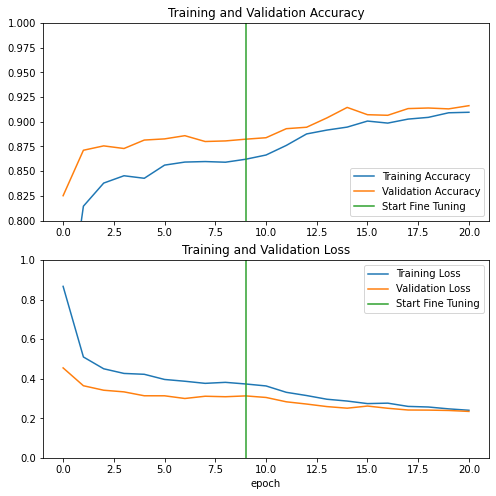

In [ ]:

acc += fine_tuning_history.history['accuracy']
val_acc += fine_tuning_history.history['val_accuracy']

loss += fine_tuning_history.history['loss']
val_loss += fine_tuning_history.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()